### 1 Warmup

In [140]:
import numpy as np
import matplotlib.pyplot as plt

In [122]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [123]:
data_all = sample_data()
data_trn = data_all[:8000]
data_val = data_all[8000:]

$$\nabla_{\theta_x} p_\theta(x) = p_\theta(x)(1-p_\theta(x))$$
$$\nabla_{\theta_{x^\prime}} p_\theta(x) = -p_\theta(x)p_\theta(x^\prime)$$
$$J(\theta) = \frac{1}{n} \sum_i -\log p_\theta(x^{(i)})$$
$$\nabla_{\theta_j} J(\theta) = \frac{1}{n} [\sum_i p_\theta(x^{(i)}) - \sum_i I(j=x^{(i)})] = \frac{1}{n} - \frac{1}{n}\sum_i I(j=x^{(i)})$$

In [149]:
class Solver():
    def __init__(self, lr=5e-4, batch_size=500, num_epochs=10000, log_every_epoch=50):
        self.lr = lr
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.log_every_epoch = log_every_epoch
        self.theta = np.zeros(100)
    
    def compute_loss(self, batch):
        theta_entries = self.theta[batch]
        stab = np.max(theta_entries) # stablizer
        probs = np.exp(theta_entries - stab) / np.sum(np.exp(self.theta - stab)) # array of p_\theta(x^{(i)}) 
        loss = np.mean(-np.log(probs))
        return loss
    
    def update(self, batch):
        n = len(batch)
        gradient = np.ones(100) * 1/n
        unique, counts = np.unique(batch, return_counts=True)
        for j, count in zip(unique, counts):
            gradient[j] -= count/n
        self.theta -= self.lr * gradient
    
    def train(self, data_trn, data_val):
        loss_trn = []
        loss_val = []
        for epoch in range(self.num_epochs):
            np.random.shuffle(data_trn)
            loss_trn_batch = []
            for batch in np.array_split(data_trn, np.ceil(len(data_trn)/self.batch_size)):
                self.update(batch)
                loss = self.compute_loss(batch)
                loss_trn_batch.append(loss)
            if epoch % self.log_every_epoch == 0:
                loss_trn.append(np.mean(loss_trn_batch))
                loss_val.append(self.compute_loss(data_val))
        return loss_trn, loss_val

In [150]:
solver = Solver()
loss_trn, loss_val = solver.train(data_trn, data_val)

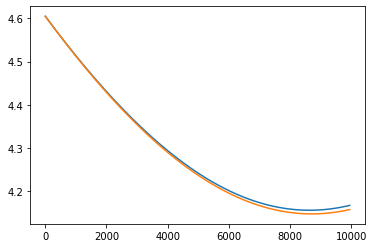

In [151]:
epochs = list(range(0, solver.num_epochs, solver.log_every_epoch))
plt.plot(epochs, loss_trn)
plt.plot(epochs, loss_val)

(array([ 24., 118., 343., 333., 160.,  24.,   8., 234., 677.,  79.]),
 array([ 1. , 10.5, 20. , 29.5, 39. , 48.5, 58. , 67.5, 77. , 86.5, 96. ]),
 <a list of 10 Patch objects>)

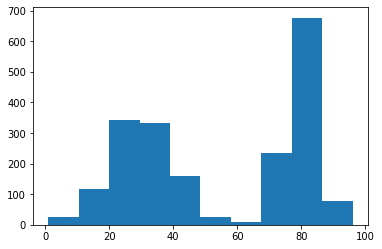

In [152]:
plt.hist(data_val)

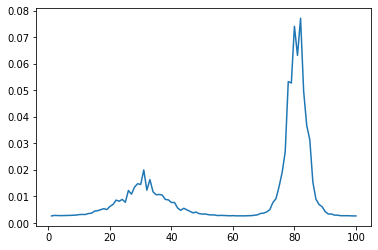

In [153]:
probs = np.exp(solver.theta - np.max(solver.theta))
probs /= np.sum(probs)
plt.plot(range(1, 101), probs)

(array([ 61.,  86., 205., 226.,  81.,  60.,  57., 550., 617.,  57.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

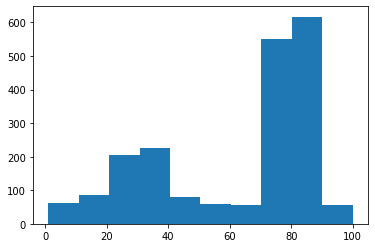

In [154]:
data_generated = np.random.choice(range(1, 101), size=2000, replace=True, p=probs)
plt.hist(data_generated)

### 2 Two-dimensional data

In [155]:
distribution = np.load('./distribution.npy')

(200, 200)